In [ ]:
# REF https://wikidocs.net/44249
# 위키북스 > 딥러닝을 이용한 자연어 처리 입문 > 10.RNN을 이용한 텍스트 분류 > 10-06 

# RED https://wikidocs.net/50739
# 한국어 word2vec

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1cfdf52fb88>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
train_data  # 'label' is binary type data, shows whether doc is +(1)/-(0)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [5]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [6]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
train_data.shape

(146183, 3)

In [9]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


In [10]:
train_data.isnull().values.any() # find nulls in doc

True

In [11]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [12]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.isnull().values.any() # Null 값이 존재하는지 확인

False

In [14]:
train_data.shape

(146182, 3)

In [15]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data

D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [16]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\sd_env\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


id            0
document    789
label         0
dtype: int64

In [17]:
train_data.loc[train_data.document.isnull()]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0
...,...,...,...
149309,6715725,NaN,1
149358,6780491,NaN,0
149364,8014701,NaN,1
149630,3508604,NaN,0


In [18]:
train_data = train_data.dropna(how = 'any')
train_data.shape

(145393, 3)

In [19]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
len(test_data)

D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


48852

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [21]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [22]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 145393/145393 [04:35<00:00, 527.40it/s]


In [23]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [24]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 48852/48852 [01:40<00:00, 486.97it/s]


In [25]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 
# 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을. 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)

In [26]:
tokenizer.word_index # 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었. 

{'영화': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '다': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '로': 17,
 '아니다': 18,
 '않다': 19,
 '점': 20,
 '에서': 21,
 '만들다': 22,
 '나오다': 23,
 '연기': 24,
 '것': 25,
 '평점': 26,
 '내': 27,
 '최고': 28,
 '그': 29,
 '나': 30,
 '안': 31,
 '인': 32,
 '스토리': 33,
 '생각': 34,
 '못': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '감동': 39,
 '사람': 40,
 '보고': 41,
 '이렇다': 42,
 '말': 43,
 '고': 44,
 '아깝다': 45,
 '더': 46,
 '배우': 47,
 '때': 48,
 'ㅋㅋ': 49,
 '아': 50,
 '감독': 51,
 '거': 52,
 '그냥': 53,
 '재미있다': 54,
 '요': 55,
 '재미': 56,
 '시간': 57,
 '내용': 58,
 '뭐': 59,
 '까지': 60,
 '중': 61,
 '주다': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '쓰레기': 67,
 '수': 68,
 '네': 69,
 '모르다': 70,
 '가다': 71,
 '들다': 72,
 '그렇다': 73,
 '싶다': 74,
 '지': 75,
 '작품': 76,
 '사랑': 77,
 '알다': 78,
 '하나': 79,
 '다시': 80,
 '마지막': 81,
 '볼': 82,
 '이건': 83,
 '정도': 84,
 '저': 85,
 '완전': 86,
 '오다': 87,
 'ㅋ': 88,
 'ㅠㅠ': 89,
 '많다': 90,
 '처음': 91,
 'ㅋㅋㅋ': 92,
 '장면': 9

In [27]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [28]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [29]:
tokenizer = Tokenizer(vocab_size) # 단어 집합의 크기를 케라스 토크나이저 인자로, 텍스트 시퀀스 >> 정수 시퀀스로. 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train[:3] # 확인

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 2315, 5671, 2, 222, 9]]

In [30]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label']) # train_data에서 y_train과 y_test를 별도로 저장해줍니다 .

In [31]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] # 빈도수 조건 탈락 샘플 삭제 

In [32]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


D:\Anaconda3\envs\sd_env\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


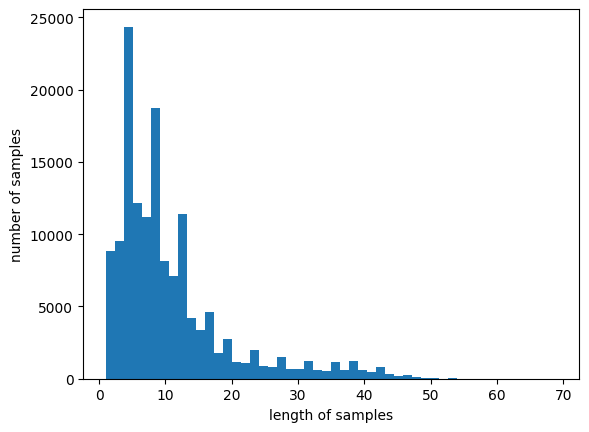

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업. 
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py



embedding_dim = 100  # hyperparam embedding vector dimension 
hidden_units = 128

model = Sequential()  #  마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델. 
# 출력층에 로지스틱 회귀를 사용해야. 
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))  # 활성화함수 sigmoid

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터 손실(val_loss)이 증가하면 >> 과적합 징후. 
# 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료.. 

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=3, save_best_only=True)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장. 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])  # 손실함수 crossentropy
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)  
# validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용. 

Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.4092 - acc: 0.8107
Epoch 1: val_acc improved from -inf to 0.83598, saving model to best_model.h5
1815/1815 [==============================] - 57s 30ms/step - loss: 0.4092 - acc: 0.8107 - val_loss: 0.3735 - val_acc: 0.8360
Epoch 2/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3458 - acc: 0.8497
Epoch 2: val_acc improved from 0.83598 to 0.84445, saving model to best_model.h5
1815/1815 [==============================] - 52s 28ms/step - loss: 0.3458 - acc: 0.8497 - val_loss: 0.3533 - val_acc: 0.8445
Epoch 3/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3201 - acc: 0.8629
Epoch 3: val_acc improved from 0.84445 to 0.84945, saving model to best_model.h5
1815/1815 [==============================] - 51s 28ms/step - loss: 0.3201 - acc: 0.8629 - val_loss: 0.3420 - val_acc: 0.8494
Epoch 4/15
1813/1815 [============================>.] - ETA: 0s - loss: 0.2977 - acc: 0.8755
Epoch 4: val_

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 6ms/step - loss: 0.3410 - acc: 0.8527

 테스트 정확도: 0.8527


In [40]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [41]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 330ms/step
84.85% 확률로 긍정 리뷰입니다.



In [42]:
sentiment_predict('기대했었는데...')

1/1 [==============================] - 0s 23ms/step
67.87% 확률로 부정 리뷰입니다.



In [43]:
sentiment_predict('흠')

1/1 [==============================] - 0s 21ms/step
59.34% 확률로 부정 리뷰입니다.



In [44]:
sentiment_predict('생각보다')

1/1 [==============================] - 0s 20ms/step
71.82% 확률로 긍정 리뷰입니다.



In [45]:
sentiment_predict('생각보다 그냥')

1/1 [==============================] - 0s 21ms/step
58.41% 확률로 긍정 리뷰입니다.



In [46]:
sentiment_predict('그냥')

1/1 [==============================] - 0s 20ms/step
72.78% 확률로 부정 리뷰입니다.



In [47]:
sentiment_predict('생각보다 그냥 그저')

1/1 [==============================] - 0s 21ms/step
91.89% 확률로 부정 리뷰입니다.



In [48]:
sentiment_predict('그저')

1/1 [==============================] - 0s 21ms/step
92.01% 확률로 부정 리뷰입니다.



In [51]:
test_lot = [
    '오래 기다렸어요',
    '주차권이 아까워요',
    '이게 5천만 관객이나 봤다고? 에이 설마',
    '창의적인 리뷰를 쓰고 싶은데... 참 힘드네요',
    '오늘 제일 좋았던 기억은 영화를 보면서 먹은 팝콘이 되겠네요',
    '여자친구랑 몰래 손 잡아봤어요!헤헿',
    '주차가 오래 걸렸어요',
    '주차 처리를 안해줘요',
    '팝콘이 맛없었어요',
    '사람들이 뭐라던가요?'
]

In [52]:
[sentiment_predict(x) for x in test_lot]

1/1 [==============================] - 0s 18ms/step
93.15% 확률로 긍정 리뷰입니다.

1/1 [==============================] - 0s 18ms/step
85.39% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 16ms/step
96.06% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 17ms/step
89.46% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 17ms/step
94.40% 확률로 긍정 리뷰입니다.

1/1 [==============================] - 0s 18ms/step
54.68% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 19ms/step
52.58% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 17ms/step
71.59% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 17ms/step
95.44% 확률로 부정 리뷰입니다.

1/1 [==============================] - 0s 18ms/step
81.24% 확률로 부정 리뷰입니다.



[None, None, None, None, None, None, None, None, None, None]

# word2vec

In [2]:
from gensim.models.word2vec import Word2Vec

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1c9aa7e0f88>)

In [7]:
train_data = pd.read_table('ratings.txt')

In [8]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [9]:
len(train_data)

200000

In [12]:
train_data.isnull().any()

id          False
document     True
label       False
dtype: bool

In [13]:
train_data = train_data.dropna(how='any')
train_data.isnull().any()

id          False
document    False
label       False
dtype: bool

In [14]:
len(train_data)

199992

In [15]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 여기까지는 같은 전처리 과정. 

D:\Anaconda3\envs\sd_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [16]:
# 불용어 사전 만드는데 그 난리
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [06:18<00:00, 527.71it/s]


In [30]:
tokenized_data

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'],
 ['디자인',
  '을',
  '배우다',
  '학생',
  '외국',
  '디자이너',
  '그',
  '일군',
  '전통',
  '을',
  '통해',
  '발전',
  '문화',
  '산업',
  '부럽다',
  '사실',
  '우리나라',
  '에서도',
  '그',
  '어렵다',
  '시절',
  '끝',
  '까지',
  '열정',
  '을',
  '지키다',
  '노라노',
  '같다',
  '전통',
  '있다',
  '저',
  '같다',
  '사람',
  '꿈',
  '을',
  '꾸다',
  '이루다',
  '나가다',
  '수',
  '있다',
  '것',
  '감사하다'],
 ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고'],
 ['오다',
  '연기',
  '진짜',
  '개',
  '쩔다',
  '지루하다',
  '생각',
  '몰입',
  '보다',
  '그렇다',
  '이렇다',
  '진짜',
  '영화',
  '지'],
 ['안개', '자욱하다', '밤하늘', '뜨다', '있다', '초승달', '같다', '영화'],
 ['사랑', '을', '해보다', '사람', '라면', '처음', '부터', '끝', '까지', '웃다', '있다', '영화'],
 ['완전', '감동', '이다', '다시', '보다', '감동'],
 ['개', '전쟁', '나오다', '나오다', '빠', '로', '보고', '싶다'],
 ['굿'],
 ['바보', '아니다', '병', '쉰', '이다'],
 ['내',
  '나이',
  '같다',
  '영화',
  '지금',
  '보다',
  '나',
  '감동',
  '적',
  '이다',
  '하지만',
  '훗날',
  '다시',
  '보다',
  '사하나',
  '하',
  '나',
  '그',
  '감정',
  '을',
  '완벽하다',
  '이해',

In [19]:
model = Word2Vec(sentences = tokenized_data, window = 5, min_count = 5, workers = 4, sg = 0)

In [20]:
model.wv.vectors.shape

(16477, 100)

In [21]:
model.wv.most_similar("최민식")

[('송강호', 0.8671071529388428),
 ('한석규', 0.8663159608840942),
 ('안성기', 0.8585988879203796),
 ('김명민', 0.8451270461082458),
 ('최민수', 0.8427635431289673),
 ('김수현', 0.8339701890945435),
 ('설경구', 0.8289908170700073),
 ('박중훈', 0.8274906277656555),
 ('양동근', 0.8240813612937927),
 ('워싱턴', 0.819753110408783)]

In [22]:
model.wv.most_similar("히어로")

[('슬래셔', 0.872411847114563),
 ('느와르', 0.8444641828536987),
 ('무협', 0.84063720703125),
 ('호러', 0.8398389220237732),
 ('물', 0.8310434818267822),
 ('무비', 0.8263506293296814),
 ('물의', 0.8066134452819824),
 ('정통', 0.8038277626037598),
 ('블록버스터', 0.8012410402297974),
 ('멜로', 0.7975677251815796)]

In [29]:
model.wv.most_similar("애나벨")

[('컨저링', 0.7921922206878662),
 ('세븐', 0.7704711556434631),
 ('밨는데', 0.7619631886482239),
 ('탄도', 0.7585083842277527),
 ('가필드', 0.7517361044883728),
 ('스폰지밥', 0.748043954372406),
 ('에필로그', 0.7407601475715637),
 ('행오버', 0.7361807227134705),
 ('이티', 0.7356320023536682),
 ('테이큰', 0.734257161617279)]